# PaperTrade

This notebook applies the generated Buy/Sell signals to DepotManager.

1. Notebook loads `MACD_BuySell_<par1>_<par2>_<par3>.ipynb`
1. Use papermill module to extract the data file `MACD_BuySell_<stock data file>_<par1>_<par2>_<par3>.csv` from the notebook.
1. Load the csv data
1. Run buy/sell data against DepotManager

In [1]:
# notebook name, where the 
nb_file = '../data/interim/MACD_BuySell_12_26_9.ipynb'

# initial balance of the depot 
balance = 2000


#### Some installs and imports

In [2]:
# Install a pip module in the current Jupyter kernel
import sys

try:   
    import seaborn as sns
except ImportError as err:
    print("Handling run-time error: ", err)
    print("Will now install missing module.")
    !{sys.executable} -m pip install seaborn
    
try:
    import papermill as pm
except ImportError as err:
    print("Handling run-time error: ", err)
    print("Will now install missing module.")
    !{sys.executable} -m pip install papermill


Handling run-time error:  No module named 'seaborn'
Will now install missing module.
    100% |################################| 215kB 1.4MB/s ta 0:00:01
Handling run-time error:  No module named 'papermill'
Will now install missing module.
    100% |################################| 133kB 1.7MB/s ta 0:00:01
    100% |################################| 51kB 3.8MB/s ta 0:00:01
    100% |################################| 61kB 3.5MB/s ta 0:00:01
    100% |################################| 4.6MB 7.5MB/s eta 0:00:01 2% |                                | 102kB 3.0MB/s eta 0:00:02


    100% |################################| 552kB 2.3MB/s ta 0:00:01


In [3]:
# other imports
import os
import math

# manipulating data
import pandas as pd
import numpy as np
#from stockstats import StockDataFrame as Sdf

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.style as style 

# notebook parameterizing and automation 
import papermill as pm

## Load Buy/Sell Signals from a Notebook

Use papermill to load the notebook `nb_file`and extract the csv file location containing buy/sell signals. Finally, it loads the csv file into a dataframe. 

In [4]:
# load the notebook and extract the csv file location
nb = pm.read_notebook(nb_file)

# extract csv file location 
output_data_path = nb.dataframe[nb.dataframe['name']=='output_data_path']['value'].values[0]
csv = nb.dataframe[nb.dataframe['name']=='csv']['value'].values[0]
csv_file = os.path.join(output_data_path, csv )

In [5]:
stock = pd.read_csv(csv_file, delimiter=';', header=0)
stock.drop(['Unnamed: 0'], axis=1, inplace=True)

## Simulate Trading

Utilizes DepotManager module to simulate trading using the stock data and the buy/sell signals. Trading uses best/worst/open stock prices at day t for the buy/sell signal at day t-1.

In [6]:
# import DepotManager

module_path = os.path.abspath(os.path.join(os.getcwd(),'../src/DepotManager'))
if module_path not in sys.path:
    sys.path.append(module_path)

import DepotManager as dp

In [7]:
#
# Paper trades the stocks using an initial balance and price mode
#

def papertrade(df, stock, bal=balance, mode='open'):
    """ Paper trading the stock.

    This function checks the buy/sell signal of day t-1
    and trades the stock at day t using best/worst/open price.
    Finally, it adds a new column to dataframe df named balance_<mode>.
    
    :param df: data
    :param stock: stock name
    :param bal: initial balance
    :param mode: decides what price to use for buy/sell
    
    mode: 
        open: always use the open price of the current business day for buy and sell
        close: always use the close price of the current business day for buy and sell
        best: use the current day's low price for buy; current day's high price for sell
        worst: use the current day's high price for buy; current day's low price for sell
        
    
    :return: None
    """

    # instanciate the DepotManager and built a new depot
    dpMngr = dp.DepotManager()
    dpWKN = dpMngr.buildDepot(stock + '_' + mode)
    # charge up with balance
    dpWKN.broker.balance = bal
    
    # correct order of data
    df.sort_index(ascending=True)
    # initialize col
    bal_col = 'balance_' + mode
    df[bal_col] = math.nan
    df.at[0, bal_col]=dpWKN.broker.balance

    for i in range(1, len(df)):

        avail_balance = dpWKN.broker.balance - 30
        avail_shares = dpWKN.totalStockinDepot()
        date = df.at[i, 'date']

        # buy
        if df.at[i-1, 'signal'] == 1:
            #print('buy')
            if mode == 'open':
                price = df.at[i, 'open']
            if mode == 'close':
                price = df.at[i, 'close']
            if mode == 'best':
                price = df.at[i, 'low']
            if mode == 'worst':
                price = df.at[i, 'high']
                
            shares = math.floor(avail_balance/price)
            dpWKN.buy(date, shares, price )

        # sell
        if df.at[i-1, 'signal'] == -1:
            #print('sell')
            if mode == 'open':
                price = df.at[i, 'open']
            if mode == 'close':
                price = df.at[i, 'close']
            if mode == 'best':
                price = df.at[i, 'high']
            if mode == 'worst':
                price = df.at[i, 'low']

            dpWKN.sell(date, avail_shares, price )

        # hold
        #if df.at[i, 'signal'] == 0:
            #print('hold')
            # nothing to do here

        # Store the final balance in stock frame
        df.at[i, bal_col] = dpWKN.broker.balance
        

In [8]:
# Run paper trade through all modes
for mode in ['open', 'close', 'best', 'worst'] :
    papertrade(df=stock, stock='840400', bal=balance, mode=mode)

## Visualize Results

Plot of closing price, the buy/sell signals and the available balance according to the various modi, e.g. open, close, best, worst.

In [9]:
#
# Returns all balances after sell signals.
#
def balances_after_sell(df, colname):
    """ Returns all balances after sell signals.

    A sell signal at day t, the balance is booked at day t+1.
    This function returns all balances at t+1 after sell signal at t.

    :param df: stock data
    :param stock: name of balance column 
    
    :return: balances in percentage
    """
    
    # sell signals indices 
    sell_idx = df[df['signal']==-1].index
    max_sell_idx = sell_idx.max()
    max_stock_idx = df.index.max()

    # the true balance is the value after the sell signal
    # we need to exclude the last index, if the max sell index is the last stock index
    if max_sell_idx == max_stock_idx:
        # remove the last index
        sell_idx = sell_idx[0:-1]

    # increase every index to get the balance index 
    bal_idx = sell_idx + 1
    # retrieve the balance in pct
    bal_pct = df.loc[bal_idx][colname]/balance
    
    return bal_pct
    

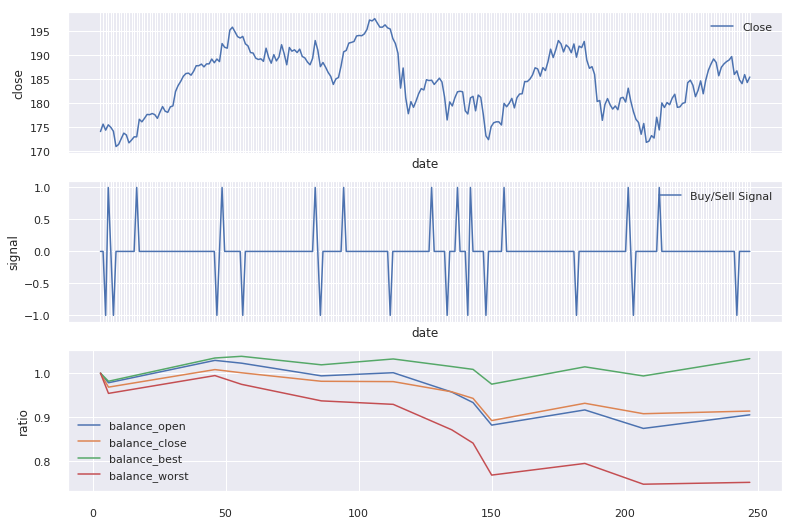

In [18]:
# set plot style
style.use('seaborn-poster')
style.use('seaborn-white')
sns.set(style="darkgrid")

# Create a figure instance, and the two subplots
fig = plt.figure()
ax1 = fig.add_subplot(311) # 3x1, fig.1
ax2 = fig.add_subplot(312) # 3x1, fig.2
ax3 = fig.add_subplot(313) # 3x1, fig.3

# Stock data
sns.lineplot(data=stock, x='date', y='close', label='Close', ax=ax1)
# Buy/Sell Signal
sns.lineplot(data=stock, x='date', y='signal', label='Buy/Sell Signal', ax=ax2)
# Balance 
for mode in ['open', 'close', 'best', 'worst'] :
    bal_col = 'balance_' + mode
    bal = balances_after_sell(stock, bal_col)
    sns.lineplot(x=bal.index, y=list(bal), label=bal_col, ax=ax3)


#sns.lineplot(data=stock, x='date', y='balance_open', label='balance_open', markers=True, dashes=False, ax=ax3)
#sns.lineplot(data=stock, x='date', y='balance_close', label='balance_close', markers=True, dashes=False, ax=ax3)
#sns.lineplot(data=stock, x='date', y='balance_best', label='balance_best', markers=True, dashes=False, ax=ax3)
#sns.lineplot(data=stock, x='date', y='balance_worst', label='balance_worst', markers=True, dashes=False, ax=ax3)


# remove ticks and labels 
ax1.tick_params(labelbottom=False, bottom=False)
ax2.tick_params(labelbottom=False, bottom=False)   

# format ticks
#l=stock.date.count()/12
#plt.xticks(stock.date[0::int(l)], rotation=45)
#plt.setp(ax3,yticks=[0,5])
plt.ylabel("ratio")
plt.show()

## Result Statistics

Compute descriptive stats across various balances modi, e.g. balance computed using open/close/.. prices.

#### Balance Statistics

In [ ]:
# 
# mode; val; stat
# ...
balance_stats = pd.DataFrame()

for mode in ['open', 'close', 'best', 'worst'] :
    bal_col = 'balance_' + mode
    
    ###########################################
    # max: maximum balance during paper trade
    ###########################################
    bal_pct = balances_after_sell(stock, bal_col)
    max_balance = bal_pct.max()
   
    ###########################################
    # latest: balance after last sell order
    ###########################################
    bal_pct = balances_after_sell(stock, bal_col)
    latest_balance = bal_pct[-1:].values[0]

    ###########################################
    # trend: linear regression trend
    ###########################################
    bal_pct = balances_after_sell(stock, bal_col)
    # compute the trend
    coeff, residuals, rank, singular_values, rcond = np.polyfit(bal_pct.index, list(bal_pct), 1, full=True)
    # balance trend
    trend_balance = coeff[0]
    
    #print('coeff: ', coeff)
    #print('residuals: ', residuals)
    #print('rank: ', rank)
    #print('singular_values: ', singular_values)
    #print('rcond: ', rcond)    
    
    ###########################################
    # aggregate all together in dataframe
    ###########################################
    vals = [max_balance, latest_balance, trend_balance]
    stat_desc = ['max', 'latest', 'trend']
    d = {'mode': bal_col, 'val': vals, 'stat': stat_desc}
    
    # add balance_mode to balance_stats dataframe
    balance_stats = pd.concat([balance_stats, pd.DataFrame(data = d)])


#### Signal Statistics

In [ ]:
#
# ...
#

#### Visualize Statistics

In [ ]:
# set plot style
style.use('seaborn-paper')
style.use('seaborn-white')
sns.set(style="darkgrid")

# reindex the dataframe to standard integer index
balance_stats.reset_index(drop=True, inplace=True)
# plot the balance_stats
sns.pointplot(data=balance_stats, x='mode', y='val', hue='stat', markers=["o", "o", "x"], linestyles=["-", "-", "--"])
plt.ylabel("Ratio")

# label the trend
labels = balance_stats[balance_stats['stat']=='trend'].values[:,0]
for l in range(0, len(labels)): 
    trend_label = round(balance_stats[balance_stats['stat']=='trend'].values[l,2], 4)
    plt.annotate(str(trend_label), xy = (1*l-0.2,trend_label+.1), xytext = (0, 0), textcoords = 'offset points')

plt.xticks(rotation=45)
plt.show()
